In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 22:03:31 2020

@author: nathanl

"""

#import the necessary stuff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import InterpolatedUnivariateSpline
from ripser import ripser
from persim import plot_diagrams
import scipy.io.wavfile
from IPython.display import clear_output
from IPython.display import Audio
from MusicFeatures import *
#from densityCheck import densityCheck
import librosa
import librosa.display
import os
import pickle
import gc
import persim
import CSMSSMTools
import densityChecked

In [28]:
# These work

def get_waveform(file_name, should_plot = False):
    #load in song and display it as waveform
    Fs, X = scipy.io.wavfile.read(file_name)
    X = X/(2.0**15) #in as 16 bit shorts, convert to float
    if(should_plot) :
        plt.figure()
        plt.plot(np.arange(len(X))/float(Fs), X)
        plt.xlabel("Time (secs)")
        plt.title("Song Name")
        plt.show()
    return Fs, X

def get_all_waveforms(filepaths):
    sampling_rates = []
    waveforms = []
    for path in filepaths:
        print(path)
        Fs, X = get_waveform(path)
        sampling_rates.append(Fs)
        waveforms.append(X)
    return sampling_rates, waveforms

In [29]:
# Works fine

#sliding window, assuming integer x, dim, Tau
def slidingWindowInt(x, dim, Tau, dT, duration = 3, mono = True):
    N = len(x)
    numWindows = int(np.floor((N-dim*Tau)/dT)) #number of windows
    if numWindows <= 0:
        print("Error: Tau too large")
        return np.zeros((duration, dim))
    X = np.zeros((numWindows, dim)) #2D array to store the windows
    idx = np.arange(N)
    for i in range(numWindows):
        #indices of the samples in window
        idxx = np.array(dT*i + Tau*np.arange(dim), dtype=np.int32)
        # This changes based on whether you have mono or stereo audio
        if(mono):
            X[i, :] = x[idxx]
        else:
            X[i, :] = x[idxx][:,0]
    return X

def get_all_embeddings(X_arr, dim_arr, Tau_arr, dT_arr):
    Y_arr = []
    for i in range(len(X_arr)):
        Y = slidingWindowInt(X_arr[i], dim_arr[i], Tau_arr[i], dT_arr[i])
        print(Y)
        Y_arr.append(Y)
    return Y

In [30]:
# Works fine

def compute_novfn(X, Fs, winSize, hopSize, plot_spectrogram = False, plot_novfn = False):
    #Compute the power spectrogram and audio novelty function
    (S, novFn) = getAudioNoveltyFn(X[:,0], Fs, winSize, hopSize)
        
    if plot_spectrogram:    
        plt.figure()
        plt.imshow(np.log(S.T), cmap = 'afmhot', aspect = 'auto')
        plt.title('Log-frequency power spectrogram')
        plt.show() 

    if plot_novfn:              
        plt.figure(figsize=(8, 4))
        #Plot the spectrogram again
        plt.subplot(211)
        plt.imshow(np.log(S.T), cmap = 'afmhot', aspect = 'auto')
        plt.ylabel('Frequency Bin')
        plt.title('Log-frequency power spectrogram')

        #Plot the audio novelty function
        plt.subplot(212)
        plt.plot(np.arange(len(novFn))*hopSize/float(Fs), novFn)
        plt.xlabel("Time (Seconds)")
        plt.ylabel('Audio Novelty')
        plt.xlim([0, len(novFn)*float(hopSize)/Fs])
        plt.show()

    return S,novFn

def compute_all_novfn(X_arr, Fs_arr, winSizes, hopSizes):
    S_arr = []
    novFn_arr = []
    for i in range(len(X_arr)):
        X = X_arr[i]
        Fs = Fs_arr[i]
        winSize = winSizes[i][0]
        hopSize = hopSizes[i][0]
        S, novFn = compute_novfn(X, Fs, winSize, hopSize)
        S_arr.append(S)
        novFn_arr.append(novFn)
    return S_arr, novFn_arr

In [31]:
def compute_chroma(X, Fs):
    chroma = librosa.feature.chroma_stft(X[:,0], Fs)
    return chroma

# Not used anywhere
def compute_all_chroma(X_arr, Fs_arr):
    chroma_arr = []
    for i in range(len(X_arr)):
        chroma_arr.append(compute_chroma(X_arr[i], Fs[i]))
    return chroma_arr

In [32]:
# Works fine

# Y is the data, dim is the MAX dimensional homology we want to compute
def compute_pd(Y, dim = 1, plot_points = True, plot_dgm = True, filter_by_density = False):
    # Mean-center and normalize
    print(Y.shape)
    Y = Y - np.mean(Y, 1)[:, None]
    # Cheating a little here
    Y = Y/np.sqrt(np.sum(Y**2, 1)+1)[:, None]
    PDs = ripser(Y, dim)['dgms']
    pca = PCA()
    Z = pca.fit_transform(Y)
    densityChecker(Z, 0.2, 5)

    #print(pca.explained_variance_ratio_)

    # Plot point cloud and persistence diagram for song
    plt.figure(figsize=(8, 4))    
    if(plot_points):
        plt.subplot(121)
        plt.title("2D PCA")
        plt.scatter(Z[:, 0], Z[:, 1])
    if(plot_dgm):
        plt.subplot(122)
        plot_diagrams(PDs)
        # Below line doesn't work since I refactored code
        #plt.title("Persistence Diagram, dim = "+str(dim)+" tau = "+str(Tau) + "dT" + str(dT))
    if(plot_points or plot_dgm):
        plt.show()

    return PDs 

# This dimension actually means specifically the dimension of homology feature you want
def compute_all_pds(Y_arr, dim = 1):
    dgms = []
    for Y in Y_arr:
        PDs = compute_pd(Y, dim, plot_points = False, plot_dgm = False)
        dgms.append(PDs[dim])
    return dgms

In [33]:
# Starts from scratch
# Compute persistence diagrams corresponding to one song (one for each segment)
# Valid feature types: novfn, chroma
def compute_pds_for_specific_song_split(X, Fs, song_name, splits, split_num, tempo, dim = 20, dT = 2, store = True, feature_type = "novfn", chroma_num = 0):
    if split_num == 0:
            start_point = 0
    else:
        start_point = Fs*splits[split_num-1]
    if split_num == len(splits):
        end_point = len(X)
    else:
        end_point = Fs*splits[split_num]
    
    windowSize = 512
    hopSize = 256
    
    if(end_point - start_point > 30):
        windowSize = 1024
        hopSize = 512
    
    if(end_point - start_point > 60):
        windowSize = 2048
        hopSize = 1024
    
    if(feature_type == "novfn"):
        # Compute novelty function
        S, novFn = compute_novfn(X[start_point:end_point], Fs, windowSize, hopSize)

        Tau = Fs * 120 /(hopSize * dim * tempo)
        Y = slidingWindowInt(novFn, dim, Tau, dT)

    if(feature_type == "chroma"):
        hopSize *= 8
        # For some reason we get stereo here
        chroma = librosa.feature.chroma_stft(X[start_point:end_point,0], Fs, hop_length = 512)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title('Chromagram')
        plt.tight_layout()
        dim = 20
        Tau = Fs * 240 /(hopSize * dim * tempo)
        dT = 2
        print(chroma.shape)
        Y = slidingWindowInt(chroma[chroma_num,:], dim, Tau, dT)
        
    dgms = compute_pd(Y)
    
    # Store pickle of matrix for persistence diagram
    if(store):
        savepath = song_name + "_" + str(start_point) + "_"  + str(end_point)
        
        if(feature_type == "chroma"):
            savepath = "chroma_"+str(chroma_num)+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)+"_chroma"+str(chroma_num)
        
        outfile = open(savepath, "wb")
        pickle.dump(dgms, outfile)
        outfile.close()
    return dgms 

# Input splits as timestamps
def compute_pds_for_full_song(X, Fs, song_name, splits, tempo, dim = 20, dT = 2, store = True, feature_type = "novfn"):
    all_dgms = []
    for i in range(len(splits)+1):
        if(feature_type == "novfn"):
            dgms = compute_pds_for_specific_song_split(X,Fs, song_name, splits, i, tempo, dim, dT, store, feature_type)  
            all_dgms.append(dgms)
        if(feature_type == "chroma"):
            for chroma_num in range(12):
                dgms = compute_pds_for_specific_song_split(X,Fs, song_name, splits, i, tempo, dim, dT, store, feature_type, chroma_num)  
                all_dgms.append(dgms)
            
    return all_dgms

# segments should be fed in as arrays of arrays of size two consisting of start and end point
# Start and end point should be fed in as array indices
def compute_pds_from_filepath(song_name, song_filepath, splits, tempo, dim = 20, dT = 2, store = True, feature_type = "novfn"):
    # Get waveform
    Fs, waveform = get_waveform(song_filepath)
    
    endpoint = len(waveform)

    all_dgms = compute_pds_for_full_song(waveform, Fs, song_name, splits, tempo, dim, dT, store, feature_type)
        
    return all_dgms, endpoint


In [34]:
# Not tested yet

# Compute and visualize clusters given list of diagrams
def compute_clusters(famemonster_dgms, artpop_dgms, chromatica_dgms, plot_clusters = True):
    all_dgms = np.concatenate([famemonster_dgms, artpop_dgms, chromatica_dgms])
    num_dgms = len(all_dgms)
    
    famemonster_length = len(famemonster_dgms)
    artpop_length = len(artpop_dgms)
    chromatica_length = len(chromatica_dgms)

    # Compute the distance matrix
    distance_matrix = np.empty([num_dgms,num_dgms])
    for i in range(num_dgms):
        for j in range(num_dgms):
            if i == j:
                distance_matrix[i][i] = 0
            else:
                distance_matrix[i][j] = persim.bottleneck(all_dgms[i][1], all_dgms[j][1])
    
    # Compute the MDS embedding
    embedding = sklearn.manifold.MDS(n_components = 2, random_state = 0, dissimilarity = 'precomputed')        
    coords = embedding.fit_transform(distance_matrix)
    x = coords[:,0]
    y = coords[:,1]

    # Album labels for the songs
    album = np.concatenate(np.full((len(famemonster_dgms),1), 0), np.full((len(artpop_dgms),1), 1). np.full((len(chromatica_dgms),1), 2))
    
    # Do kmeans clustering and get labels
    kmeans = sklearn.cluster.KMeans(n_clusters = 3).fit(coords)
    cluster_labels = kmeans.labels_
    print("I should have "+str(num_dgms)+"labels and I really have "+str(len(cluster_labels)))
    #plt.scatter(x,y,c=cluster_labels)
    
    # This is not a particularly elegant solution, but the simplest way I could get it to plot both different colors and different markers
    x_famemonster = x[:famemonster_length]
    y_famemonster = y[:famemonster_length]
    labels_famemonster = cluster_labels[:famemonster_length]
    
    x_artpop = x[famemonster_length:famemonster_length+artpop_length]
    y_artpop = y[famemonster_length:famemonster_length+artpop_length]
    labels_artpop = cluster_labels[famemonster_length:famemonster_length+artpop_length]
    x_chromatica = x[famemonster_length + artpop_length:famemonster_length+artpop_length + chromatica_length]
    y_chromatica = y[famemonster_length + artpop_length:famemonster_length+artpop_length + chromatica_length]
    labels_third_album = cluster_labels[famemonster_length + artpop_length:famemonster_length+artpop_length + chromatica_length]
    
    plt.figure()
    plt.scatter(x_famemonster, y_famemonster, c = labels_famemonster, marker = 'o')
    plt.scatter(x_artpop, y_artpop, c = labels_artpop, marker = 'x')
    plt.scatter(x_chromatica, y_chromatica, c = labels_third_album, marker = '+')
    plt.show()


Basic Workflow:

For any given album...

1. Compute all waveforms and sampling rates
2. Compute all window sizes and hop sizes
3. Compute novelty functions (or chroma features, or etc) 
4. Compute persistence diagrams

Repeat for each album

5. Concatenate all lists of persistence diagrams, compute the clusters

[NOTE: The above workflow does not work because of memory and computation restraints. Instead, use the modified workflow]

For each song or song snippet
1. Compute waveform and sampling rate
2. Compute window size and hop size
3. Compute novelty function
4. Compute persistence diagram
5. Store persistence diagram
6. Clear data

Then finally,

7. Compute the clusters

In [35]:
path = os.path.abspath("Lady Gaga - Shape Features.ipynb")
path = os.path.dirname(path)

# Step 1

famemonster_song_names = ['01 - Bad Romance [Explicit]', '02 - Alejandro', '03 - Monster [Explicit]', 
'04 - Speechless', '05 - Dance In The Dark [Explicit]', '06 - Telephone [feat. Beyoncé]', '07 - So Happy I Could Die', 
'08 - Teeth [Explicit]', "(Disc 2) 01 - Just Dance [feat. Colby O_Donis]", '(Disc 2) 02 - LoveGame', 
'(Disc 2) 04 - Poker Face', '(Disc 2) 07 - The Fame', '(Disc 2) 09 - Starstruck [feat. Space Cowboy _ Flo Rida]',
'(Disc 2) 11 - Paper Gangsta [Explicit]', '(Disc 2) 12 - Brown Eyes', '(Disc 2) 13 - I Like It Rough',
'(Disc 2) 14 - Summerboy', '(Disc 2) 15 - Disco Heaven']

famemonster_filepaths = []

for i in range(len(famemonster_song_names)):
    famemonster_filepaths.append(path + '/../FameMonster/' + famemonster_song_names[i] + ".wav") 

# Missing Do What U Want for some reason
artpop_song_names = ['01 - Aura [Explicit]', '02 - Venus [Explicit]', '03 - G.U.Y. [Explicit]', '04 - Sexxx Dreams [Explicit]', 
'05 - Jewels N_ Drugs [feat. T.I. _ Too $hort _ Twista] [Explicit]', '06 - MANiCURE', '07 - ARTPOP',
'08 - Swine [Explicit]', '09 - Donatella [Explicit]', '10 - Fashion!', '11 - Mary Jane Holland [Explicit]',
'12 - Dope [Explicit]', '13 - Gypsy', '14 - Applause']

artpop_filepaths = []

for i in range(len(artpop_song_names)):
    artpop_filepaths.append(path + '/../Artpop/' + artpop_song_names[i] + ".wav") 
    
chromatica_song_names = ['01 Chromatica I', '02 Alice', '03 Stupid Love', '04 Rain On Me', '05 Free Woman',
'06 Fun Tonight', '07 Chromatica II', '08 911', '09 Plastic Doll', '10 Sour Candy', '11 Enigma', '12 Replay',
'13 Chromatica III', '14 Sine From Above', '15 1000 Doves', '16 Babylon']

chromatica_filepaths = []

for i in range(len(chromatica_song_names)):
    chromatica_filepaths.append(path + '/../Chromatica/' + chromatica_song_names[i] + ".wav") 

    
famemonster_song_splits = [
    # 1 - Bad Romance
    [18, 26, 34, 66, 74, 106, 115, 147, 155, 187, 203, 220, 235, 250, 284, 292],
    # 2 - Alejandro
    [15, 26, 35, 44, 64, 73, 113, 123, 142, 152, 190, 210, 229, 248, 268],
    # 3 - Monster
    [10, 17, 25, 33, 49, 66, 81, 84, 97, 114, 129, 145, 148, 162, 177, 193, 202, 212, 229, 245],
    # 4 - Speechless
    [15, 42, 55, 82, 123, 149, 174, 196, 204, 230, 263, 267],
    # 5 Dance in the Dark
    [18, 33, 49, 77, 79, 110, 136, 156, 205, 220, 227, 239, 258, 273, 285],
    # 6 Telephone
    [9, 25, 33, 49, 64, 80, 96, 112, 120, 127, 135, 167, 182, 199, 214],
    # 7 So Happy I could Die
    [20, 39, 59, 78, 97, 117, 136, 145, 155, 164, 174, 193, 204, 231],
    # 8 Teeth
    [11, 22, 61, 82, 121, 140, 152, 172, 191, 201],
    # 1 Just Dance
    [6, 9, 17, 33, 50, 68, 84, 100, 116, 133, 148, 156, 174, 180, 197, 212, 221, 237],
    # 2 Love Game
    [10, 17, 37, 46, 55, 73, 81, 101, 110, 119, 137, 146, 165, 173, 197],
    # 4 Poker Face
    [9, 18, 26, 33, 41, 58, 74, 82, 90, 98, 114, 130, 138, 146, 155, 163, 171, 211],
    # 7 The Fame
    [4, 11, 19, 34, 49, 64, 79, 110, 125, 140, 155, 163, 170, 201],
    # 9 Starstruck
    [20, 38, 58, 76, 94, 132, 150, 169, 187, 211],
    # 11 Paper Gangsta
    [11, 20, 40, 47, 67, 87, 106, 115, 135, 145, 182, 193, 223, 252],
    # 12 Brown Eyes
    [8, 25, 55, 82, 130, 157, 173, 202, 220, 237],
    # 13 I like it Rough
    [9, 25, 41, 57, 73, 89, 104, 120, 138, 153, 184],
    # 14 Summerboy
    [13, 31, 49, 67, 77, 113, 136, 172, 218],
    # 15 Disco Heaven
    [15, 45, 75, 105, 135, 166, 197, 212]
    
]    
# An array of arrays, where subarray corresponds to splits for a given song
artpop_song_splits = [
    # 1 - Aura
    [9, 34, 56, 67, 72, 100, 137, 152, 167, 182, 215, 219],
    # 2- Venus
    [7, 40, 56, 72, 88, 104, 120, 134, 152, 167, 199, 215],
    # 3 GUY
    [18, 27, 45, 53, 62, 80, 88, 105, 121, 140, 158, 186, 220, 230],
    # 4 Sexxx Dreams
    [5, 34, 51, 56, 72, 106, 118, 140, 159, 177, 211],
    # 5 Jewels N Drugs
    [6, 20, 51, 65, 93, 107, 136, 163, 217],
    # 6 Manicure
    [16, 29, 43, 57, 85, 112, 120, 134, 148, 168],
    # 7 Artpop
    [18, 50, 85, 90, 122, 155, 172, 204, 237],
    # 8 Swine
    [9, 38, 67, 97, 127, 157, 187, 202, 217, 232, 247],
    # 9 Donatella
    [4, 8, 19, 50, 65, 81, 97, 141, 157, 172, 187, 203, 218, 249],
    # 10 Fashion
    [17, 35, 68, 100, 126, 149, 168, 184, 200],
    # 11 Mary Jane Holland
    [10, 48, 67, 86, 105, 123, 142, 161, 210, 248, 268, 275],
    # 12 Dope
    [16, 93,  108, 153, 186, 197],
    # 13 Gypsy
    [30, 45, 58, 73, 102, 116, 130, 144, 161, 171, 194, 202, 216, 231, 244],
    # 14 - Applause
    [15,56,70,83,109,143,151,164,178, 208]
]

chromatica_song_splits = [
    # Chromatica I
    [],
    # Alice
    [18, 34, 50, 65, 96, 112, 129, 143],
    # Stupid Love
    [9, 26, 41, 57, 74, 90, 108, 122, 140, 156],
    # Rain on Me
    [16, 32, 41, 46, 64, 80, 95, 109, 127, 143, 148, 166, 173],
    # Free Woman
    [9, 41, 58, 73, 91, 122, 138, 155, 170, 186],
    # Fun Tonight
    [4, 20, 36, 52, 68, 87, 102, 118, 134, 152, 172],
    # Chromatica II
    [31],
    # 911
    [9, 26, 35, 41, 59, 75, 84, 92, 108, 117, 131, 150, 167],
    # Plastic Doll
    [9, 17, 49, 63, 81, 96, 112, 144, 152, 160, 169, 202, 217],
    # Sour Candy
    [8, 10, 17, 33, 64, 81, 90, 110, 125, 142, 150],
    # Enigma
    [5, 22, 34, 48, 66, 83, 94, 112, 128, 140, 145, 174],
    # Replay
    [13, 21, 39, 55, 71, 88, 104, 122, 136, 151, 183],
    # Chromatica III
    [],
    # Sine from above
    [9, 40, 56, 71, 85, 87, 103, 119, 133, 149, 165, 178, 180, 195, 203, 209, 215, 221, 241],
    # 1000 Doves
    [17, 34, 48, 64, 80, 96, 111, 127, 143, 166, 182, 213],
    # Babylon
    [6, 10, 26, 32, 42, 50, 65, 67, 83, 89, 91, 106, 110, 124, 141, 155, 158]
]


In [36]:
# Step 2

# In beats per minute
# Do not have all the songs for famemonster
famemonster_tempos = [117,98,119,144,121, 122, 99, 96, 119, 104, 120, 132, 103, 112, 60, 120, 105, 128]
artpop_tempos = [129,121,110,113,136,138,117,127,124,116,101,128,133,139]
chromatica_tempos = [75,123,117,123,117,117,75,117,121,120,117,123,121,122,123,117]



01 - Bad Romance [Explicit]
/Users/nathanl/Desktop/TDA all/TDA-Project/../FameMonster/01 - Bad Romance [Explicit].wav


<ipython-input-28-1c4ecb5ce843>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, X = scipy.io.wavfile.read(file_name)


(12, 1551)
(769, 20)


NameError: name 'densityCheck' is not defined

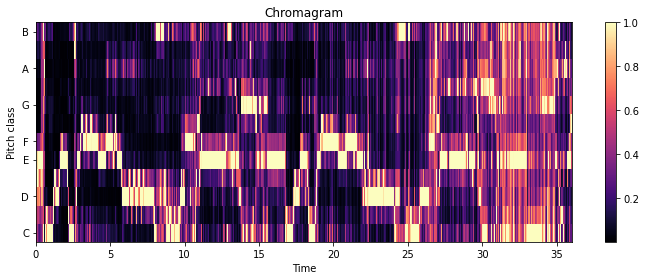

In [37]:
# DON'T RUN THIS ALL THE TIME
# Compute and store pd's across all segments of all songs in famemonster
famemonster_endpoints = []
should_record_endpoints = False

for i in range(len(famemonster_filepaths)):
    print(famemonster_song_names[i])
    print(famemonster_filepaths[i])
    dgms, endpoint = compute_pds_from_filepath(famemonster_song_names[i], famemonster_filepaths[i], famemonster_song_splits[i], famemonster_tempos[i], feature_type = "chroma")
    famemonster_endpoints.append(endpoint)

if should_record_endpoints:    
    savepath = "famemonster_endpoints"
    outfile = open(savepath, "wb")
    pickle.dump(famemonster_endpoints, outfile)
    outfile.close()

In [ ]:
# DON'T RUN THIS ALL THE TIME
# Compute and store all persistence diagrams across all segments of all songs in artpop
artpop_endpoints = []
should_record_endpoints = True

for i in range(len(artpop_filepaths)):
    print(artpop_song_names[i])
    print(artpop_filepaths[i])
    dgms, endpoint = compute_pds_from_filepath(artpop_song_names[i], artpop_filepaths[i], artpop_song_splits[i], artpop_tempos[i], feature_type = "chroma")
    artpop_endpoints.append(endpoint)
    
if should_record_endpoints:    
    savepath = "artpop_endpoints"
    outfile = open(savepath, "wb")
    pickle.dump(artpop_endpoints, outfile)
    outfile.close()

In [ ]:
# DON'T RUN THIS ALL THE TIME
# Compute and store all persistence diagrams across all segments of all songs in artpop
chromatica_endpoints = []
should_record_endpoints = True

for i in range(len(chromatica_filepaths)):
    print(chromatica_song_names[i])
    print(chromatica_filepaths[i])
    dgms, endpoint = compute_pds_from_filepath(chromatica_song_names[i], chromatica_filepaths[i], chromatica_song_splits[i], chromatica_tempos[i], feature_type = "chroma")
    chromatica_endpoints.append(endpoint)
if should_record_endpoints:    
    savepath = "chromatica_endpoints"
    outfile = open(savepath, "wb")
    pickle.dump(chromatica_endpoints, outfile)
    outfile.close()

In [34]:
# This is lazy, but works - imports all the correct stuff based on the feature type
Fs = 44100
def load_all_pds(song_names, split_points, endpoints, feature_type = "novfn", chroma_num =0):
    pds = []
    for song in range(len(song_names)):
        for split_num in range(len(split_points[song])):
            song_name = song_names[song]
            if split_num == 0:
                start_point = 0
            else:
                start_point = Fs * split_points[song][split_num-1]
            if split_num == len(split_points[song]):
                end_point = endpoints[song]
            else:
                end_point = Fs * split_points[song][split_num]
            if feature_type == "novfn":
                savepath = "novfn\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            if feature_type == "chroma":
                savepath = "chroma_"+chroma_num+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            with open(savepath, 'rb') as f:
                pds.append(pickle.load(f))
    gc.collect()
    return pds

def load_pds_grouped_by_song(song_names, split_points, endpoints, feature_type = "novfn", chroma_num =0):
    pds_by_song = []
    for song in range(len(song_names)):
        song_pds = []
        for split_num in range(len(split_points[song])):
            song_name = song_names[song]
            if split_num == 0:
                start_point = 0
            else:
                start_point = Fs * split_points[song][split_num-1]
            if split_num == len(split_points[song]):
                end_point = endpoints[song]
            else:
                end_point = Fs * split_points[song][split_num]
            if feature_type == "novfn":
                savepath = "novfn\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            if feature_type == "chroma":
                savepath = "chroma_"+chroma_num+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            with open(savepath, 'rb') as f:
                song_pds.append(pickle.load(f))
        pds_by_song.append(song_pds)
        gc.collect()
    return pds_by_song

In [ ]:
# Loads in all the persistence diagrams from the files

famemonster_pds = []
artpop_pds = []
chromatica_pds = []

with open("famemonster_endpoints", 'rb') as f:
    famemonster_endpoints = pickle.load(f)

famemonster_pds = load_all_pds(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)

with open("artpop_endpoints", 'rb') as f:
    artpop_endpoints = pickle.load(f)

artpop_pds = load_all_pds(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names,artpop_song_splits, artpop_endpoints)

with open("chromatica_endpoints", 'rb') as f:
    chromatica_endpoints = pickle.load(f)

chromatica_pds = load_all_pds(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)


In [ ]:
print(type(chromatica_pds))
print(type(chromatica_pds[0]))
print(type(chromatica_pds[0][0]))


In [ ]:
'''
pds_by_song is an array containing one array for each song. The array for each song contains 
arrays of size two corresponding to the zeroth and first homologies respectively. 

segment_indices_by_song is an array containing one array for each song. The array for each song
contains arrays corresponding to the indices of whatever segment type you want (chorus, verse, etc)
for that song
'''
def get_pds_by_indices(pds_by_song, segment_indices_by_song):
    pds_at_indices = []
    for song_index in range(len(pds_by_song)):
        for segment_index in segment_indices_by_song[song_index]:
            pds = pds_by_song[song_index][segment_index]
            pds_at_indices.append(pds)
    return pds_at_indices

In [ ]:
# Each subarray is set of indices for clips for a song

famemonster_chorus_indices = [
    # 1 - Bad Romance
    [],
    # 2 - Alejandro
    [],
    # 3 - Monster
    [],
    # 4 - Speechless
    [],
    # 5 Dance in the Dark
    [],
    # 6 Telephone
    [],
    # 7 So Happy I could Die
    [],
    # 8 Teeth
    [],
    # 1 Just Dance
    [],
    # 2 Love Game
    [],
    # 4 Poker Face
    [],
    # 7 The Fame
    [],
    # 9 Starstruck
    [],
    # 11 Paper Gangsta
    [],
    # 12 Brown Eyes
    [],
    # 13 I like it Rough
    [],
    # 14 Summerboy
    [],
    # 15 Disco Heaven
    []
]    

artpop_chorus_indices = [
    # 1 - Aura
    [],
    # 2- Venus
    [],
    # 3 GUY
    [],
    # 4 Sexxx Dreams
    [],
    # 5 Jewels N Drugs
    [],
    # 6 Manicure
    [],
    # 7 Artpop
    [],
    # 8 Swine
    [],
    # 9 Donatella
    [],
    # 10 Fashion
    [],
    # 11 Mary Jane Holland
    [],
    # 12 Dope
    [],
    # 13 Gypsy
    [],
    # 14 - Applause
    []
]

chromatica_chorus_indices = [
    # 1 Chromatica I
    [],
    # 2 Alice
    [],
    # 3 Stupid Love
    [],
    # 4 Rain on Me
    [],
    # 5 Free Woman
    [],
    # 6 Fun Tonight
    [],
    # 7 Chromatica II
    [],
    # 8 911
    [],
    # 9 Plastic Doll
    [],
    # 10 Sour Candy
    [],
    # 11 Enigma
    [],
    # 12 Replay
    [],
    # 13 Chromatica III
    [],
    # 14 Sine from above
    [],
    # 15 1000 Doves
    [],
    # 16 Babylon
    []
]

In [ ]:
famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_chorus_pds = get_pds_by_indices(famemonster_pds_by_song, famemonster_chorus_indices)

artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_chorus_pds = get_pds_by_indices(artpop_pds_by_song, artpop_chorus_indices)

chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_chorus_pds = get_pds_by_indices(chromatica_pds_by_song, chromatica_chorus_indices)

compute_clusters(famemonster_chorus_pds, artpop_chorus_pds, chromatica_chorus_pds)


In [ ]:
# Works fine

compute_clusters(famemonster_pds, artpop_pds, chromatica_pds)


In [32]:
# Cross similarity matrix
Fs, X = get_waveform(famemonster_filepaths[0])

X=X[:,0]
Xone = X[0:Fs*famemonster_song_splits[0][0]]
Xtwo = X[Fs*famemonster_song_splits[0][0]:Fs*famemonster_song_splits[0][1]]

chroma_one = librosa.feature.chroma_stft(Xone, Fs, hop_length = 512)
chroma_two = librosa.feature.chroma_stft(Xtwo, Fs, hop_length = 512)
XChroma = librosa.feature.stack_memory(chroma_one, n_steps=10, mode='edge').T
YChroma = librosa.feature.stack_memory(chroma_two, n_steps=10, mode='edge').T
DChroma = CSMSSMTools.getCSMCosine(XChroma, YChroma) #Cosine distance
ssm = CSMSSMTools.getCSMCosine(XChroma,XChroma)

<ipython-input-2-1c4ecb5ce843>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, X = scipy.io.wavfile.read(file_name)


<class 'numpy.ndarray'>
(1551, 690)


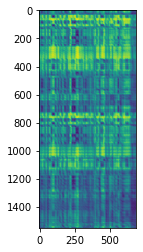

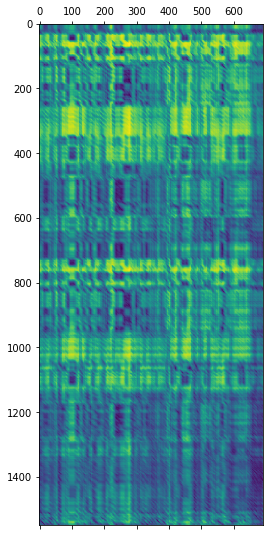

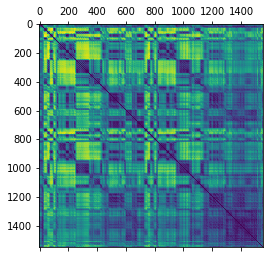

In [33]:
print(type(DChroma))
print(DChroma.shape)
W = DChroma
plt.imshow(DChroma)
plt.matshow(DChroma)
plt.matshow(ssm)

In [ ]:
''' 
Random Old Code 

with open(savepath, 'rb') as f:
    famemonster_pds.append(pickle.load(f))


# Step 3
# Can replace with whatever you want, novelty functions or chroma features or whatever

famemonster_s, famemonster_novfns = compute_all_novfn(famemonster_waveforms, famemonster_sample_rates, np.full((len(famemonster_waveforms),1), winSize), np.full((len(famemonster_waveforms),1), hopSize))
#artpop_s, artpop_novfns = compute_all_novfn(artpop_waveforms, artpop_sample_rates, np.full((len(artpop_waveforms),1), winSize), np.full((len(artpop_waveforms),1), hopSize))
#chromatica_s, chromatica_novfns = compute_all_novfn(chromatica_waveforms, chromatica_sample_rates, np.full((len(chromatica_waveforms),1), winSize), np.full((len(chromatica_waveforms),1), hopSize))

# Want window size to cover roughly two beats
# There's probably a better way to create these arrays, I just don't know it
famemonster_dim = np.full((len(famemonster_waveforms),1), 20)[0,:]
famemonster_Tau = (famemonster_sample_rates) * np.full((len(famemonster_waveforms),1), 120)[0,:]/(np.full((len(famemonster_waveforms),1),float(hopSize))[0,:] * famemonster_dim * famemonster_tempos)
famemonster_dT = np.full((len(famemonster_waveforms),1), 2)

Y = slidingWindowInt(famemonster_novfns[0], 120, famemonster_sample_rates[0]* 60/ (hopSize * 20 *117), 20)

famemonster_embeddings = get_all_embeddings(famemonster_novfns, famemonster_dim, famemonster_Tau, famemonster_dT)
#artpop_embeddings = get_all_embeddings(artpop_novfns, , , )
#chromatica_embeddings = get_all_embeddings(chromatica_novfns, , ,)

print(Y)
print()
print(famemonster_embeddings)

# Step 4

# Y is the sliding window embedding
compute_pd(Y)
#famemonster_pds = compute_all_pds(famemonster_embeddings)
#artpop_pds = compute_all_pds(artpop_embeddings)
#chromatica_pds = compute_all_pds(chromatica_embeddings)

#Take the first 3 seconds of the novelty function
fac = int(Fs/hopSize)
novFn = novFn[fac*4:fac*20]
# Chromatica I is at tempo of 66
# So window size should be about a second

#Make sure the window size is half of a second, noting that
#the audio novelty function has been downsampled by a "hopSize" factor
dim = 20
# Need Fs instead of Fs/2 because of the tempo thing - can implement a more general thing here later
Tau = (Fs)/(float(hopSize)*dim)
dT = 1


Y = slidingWindowInt(novFn, dim, Tau, dT)
print("Y.shape = ", Y.shape)

#dim*Tau here spans 1/2 second since Fs is the sample rate
Original settings 
dim = round(Fs/200)
Tau = 100
dT = Fs/100     

#dim = round(Fs/200)
dT = Fs/100     
tau_vals = [100]


for tau in tau_vals:
    dim = round(Fs/(2*tau))
    compute_pd(Fs, X, dim, tau, dT)


dim_arr = [5]
dt_arr = [2,5, 10]
for dim in dim_arr:     
    for dT in dt_arr: 
        Tau = (Fs)/(float(hopSize)*dim)

        Y = slidingWindowInt(novFn, dim, Tau, dT)
        print("Y.shape = ", Y.shape)
        print("dim: "+str(dim)+" dT: "+str(dT))
        compute_pd(Y)

Just print out the chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

print("Sample rate"+str(Fs))
chroma = librosa.feature.chroma_stft(X[:,0], Fs)


print("Chroma shape: "+str(chroma.shape))
dim = 5
Tau = 1
dT = 3
Y_chroma = slidingWindowInt(chroma[3,0:200].transpose(), dim, Tau, dT)
print("Y_chroma.shape= ", Y_chroma.shape)
compute_pd(Y_chroma)

'''